# Continuous Control

---

In this project, we develop a Deep Deterministic Policy Gradient (DDPG) agent that utilises its newly acquired skills to control a robotic arm, and steer it to a target location. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

### 0. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

### 1. Set environment parameters

Here we set env_name to the name of the Unity environment file we want to launch. We should ensure that the environment build is in the python directory.

In [2]:
env_name = "./python/Reacher_Linux/Reacher.x86_64"  # Name of the Unity environment binary to launch
train_mode = True                                   # Whether to run the environment in training or inference mode

### 2. Load dependencies

The following loads the necessary dependencies and checks the Python version (at runtime). ML-Agents Toolkit (v0.3 onwards) requires Python 3.

In [3]:
import sys
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

from unityagents import UnityEnvironment

%matplotlib inline

print("Python version:")
print(sys.version)

# check Python version
if (sys.version_info[0] < 3):
    raise Exception("ERROR: ML-Agents Toolkit (v0.3 onwards) requires Python 3")

Python version:
3.6.3 | packaged by conda-forge | (default, Nov  4 2017, 10:10:56) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


### 3. Start the environment

UnityEnvironment launches and begins communication with the environment when instantiated.

In [4]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name=env_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 4. Examine the State and Action Spaces

We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, states refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, observations refer to a set of relevant pixel-wise visuals for an agent.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 5. Take Random Actions in the Environment

Once we restart an environment, we can step the environment forward and provide actions to all of the agents within the environment. Here we simply choose random actions.

Once this cell is executed, a message will be printed that detail how much reward was accumulated during one Episode. The Unity environment will then pause, waiting for further signals telling it what to do next. Thus, not seeing any animation is expected when running this cell.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.6399999856948853


### 6. Training the agent

Now let us train our agent to solve the environment!

#### 6.1 Model Definition

To implement the [DDPG Algorithm](https://arxiv.org/abs/1509.02971), we define two simple neural networks, one for the Actor and one for the Critic. The networks have a few fully connected layers, with batch normalization in between. The latter helped stabilize the performance of the agent. For the Actor network we use ReLU activation functions on every layer except the last one, where we apply the tanh function, because we need to output values between -1 and 1. On the Critic network we again use mostly ReLU activations, except the last layer, that has no activation as it simply evaluates the output of the Actor.

First, we need to import the necessary libraries and set the hyperparameters values.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # tau parameter for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 6.1 Actor model

In the [DDPG paper](https://arxiv.org/abs/1509.02971), they introduced this algorithm as an "Actor-Critic" method. Though, some researchers think DDPG is best classified as a DQN method for continuous action spaces (along with [NAF](https://arxiv.org/abs/1603.00748)).

In DDPG, every time we query the Actor network we want to get back the best believed action for a specific, given state. That is a deterministic policy. The Actor is basically learning the function: 

$$argmax_aQ(s,a)$$

In [9]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        super(Actor, self).__init__() 
        self.seed = torch.manual_seed(seed)
        
        # Fully connected layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
        # Batch normalization operations between layers
        self.batch_norm1 = nn.BatchNorm1d(state_size)
        self.batch_norm2 = nn.BatchNorm1d(fc1_units)
        self.batch_norm3 = nn.BatchNorm1d(fc2_units)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        # Layer weight and bias initialization
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(.1)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc2.bias.data.fill_(.1)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.fc3.bias.data.fill_(.1)
        
    def forward(self, state):
        """ Build an actor (policy) network that maps states -> actions. """
        x = self.batch_norm1(state)
        x = self.relu(self.fc1(x))
        x = self.batch_norm2(x)
        x = self.relu(self.fc2(x))
        x = self.batch_norm3(x)
        x = self.tanh(self.fc3(x))
        return x 

#### 6.2 Critic model

The Critic learns to evaluate the output of the Actor, which is the estimated best action to take, given a specific state. That is to evaluate the optimal action value function, by using the Actor's best believed action.

In [10]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):      
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # Fully connected layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        # Batch normalization operation
        self.batch_norm = nn.BatchNorm1d(fc1_units)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Layer weight and bias initialization
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(.1)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc2.bias.data.fill_(.1)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.fc3.bias.data.fill_(.1)
        
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = self.relu(self.fc1(state))
        x = self.batch_norm(x)
        x = torch.cat([x, action], dim=1)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### 6.3 Create the DDPG Agent

First, we create the noise function, which helps with exploration.

In [11]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

Next, we create the experience replay buffer class

In [12]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """ Initialize a ReplayBuffer object Parameters
        
        ----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size) # internal memory i.e. the buffer 
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """ Add a new experience to the buffer. """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """ Randomly sample a batch from memory. """        
        batch = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in batch if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in batch if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in batch if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in batch if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in batch if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)                                    
        
    def __len__(self):
        """ Return the current size of memory. """
        return len(self.memory)

Last but not least we implement the DDPG agent that solves the environment.

In [13]:
class DDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.hard_copy(self.critic_local, self.critic_target)
        self.hard_copy(self.actor_local, self.actor_target)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_target_next = self.critic_target(next_states, actions_next)
        # compute Q targets for next states (y_i)
        Q_targets = rewards + (gamma * Q_target_next * (1.0 - dones))
        # Compute citic loss 
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimise loss 
        self.critic_optimizer.zero_grad() 
        critic_loss.backward() 
        self.critic_optimizer.step() 

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def hard_copy(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)

The `ddpg` function trains the agent in the given environment.

In [14]:
def ddpg(n_episodes=500, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    max_score = -np.Inf
    
    for e in range(1, n_episodes+1):
        # Reset environment 
        env_info = env.reset(train_mode=True)[brain_name]
        # Reset agent 
        agent.reset() 
        # Get the initial state 
        state = env_info.vector_observations[0]      
        # Reassign score to 0 
        score = 0 
        
        for t in range(max_t):
            # Get action 
            action = agent.act(state)           
            # Observe reaction (environment)
            env_info = env.step(action)[brain_name]        
            ## Get new state 
            next_state = env_info.vector_observations[0]
            ## Get reward 
            reward = env_info.rewards[0]
            # See if episode has finished 
            done = env_info.local_done[0]  
            # Step 
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            max_score = max(max_score, score)
            
            if done:
                break 
                
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tMax score: {:.3f}'.format(e, np.mean(scores_deque), 
                                                                              max_score), end="")
        
        if e % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
            break
    
    return scores

We now run the DDPG method to train our agent. To solve the environment, the agent must get an average score of +30 over 100 consecutive episodes.

In [17]:
# Initialize a DDPG Agent
agent = DDPGAgent(state_size=state_size, action_size=action_size, random_seed=1)

# Run the algorithm
scores = ddpg()

Episode 100	Average Score: 1.23	Max score: 4.560
Episode 200	Average Score: 9.63	Max score: 25.510
Episode 300	Average Score: 28.65	Max score: 39.430
Episode 310	Average Score: 30.20	Max score: 39.430
Environment solved in 210 episodes!	Average Score: 30.20


#### 6.4 Watch a trained agent

Watch the performance of a trained agent in this environment. The agent's robotic arm succesfully follows the target!

In [19]:
# load the weights from file
agent.actor_local.load_state_dict(torch.load('actor_checkpoint.pth'))
agent.critic_local.load_state_dict(torch.load('critic_checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 29.759999334812164


#### 6.5 Close the environment when finished

When we are finished using an environment, we can close it with the function below.

In [20]:
env.close()

### 7. Results

Here we plot the evolution of the score accumulated by our agent, by the number of episodes.

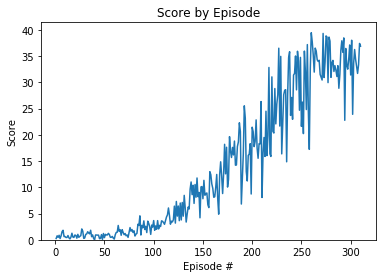

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title("Score by Episode")
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.set_ylim(ymin=0)
plt.show()